In [36]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os

In [37]:
# 1. 配置路径和设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'tomato_leaf_model_v3.pth'

In [38]:
# 2. 定义模型结构 (必须与训练时完全一致)
model = models.mobilenet_v2(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

In [39]:
# 加载保存的权重
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval() # 开启评估模式

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [40]:
# 3. 定义预处理 (必须与训练时的 val 预处理一致)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [41]:
# 4. 类别映射 (根据你的文件夹名称手动对应)
# 注意：PyTorch ImageFolder 默认按字母序排序：
# 0: Tomato__Tomato_YellowLeaf__Curl_Virus
# 1: Tomato_healthy
class_names = ['番茄黄化曲叶病毒', '健康番茄叶片']

def predict(img_path):
    # 加载图片
    img = Image.open(img_path).convert('RGB')
    # 预处理并增加 batch 维度
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        _, preds = torch.max(outputs, 1)
        # 获取概率（可选）
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf = probs[0][preds[0]].item()

    result = class_names[preds[0]]
    print(f"图片: {os.path.basename(img_path)}")
    print(f"检测结果: {result} (置信度: {conf:.2%})")
    print("-" * 30)

In [42]:
# 5. 运行预测
# 预测你文件夹下的两张图
if os.path.exists('southeast.jpeg'):
    predict('southeast.jpeg')
if os.path.exists('images2.webp'):
    predict('images2.webp')
if os.path.exists('OIP.webp'):
    predict('OIP.webp')
if os.path.exists('images (1).jpeg'):
    predict('images (1).jpeg')
    

图片: southeast.jpeg
检测结果: 健康番茄叶片 (置信度: 98.57%)
------------------------------
图片: images2.webp
检测结果: 番茄黄化曲叶病毒 (置信度: 99.95%)
------------------------------
图片: OIP.webp
检测结果: 健康番茄叶片 (置信度: 99.28%)
------------------------------
图片: images (1).jpeg
检测结果: 番茄黄化曲叶病毒 (置信度: 96.20%)
------------------------------


In [43]:
def check_raw_index(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)
        print(f"图片 {img_path} 的模型预测原始索引是: {preds.item()}")

check_raw_index('images.jpeg')
check_raw_index('images (1).jpeg')

图片 images.jpeg 的模型预测原始索引是: 0
图片 images (1).jpeg 的模型预测原始索引是: 0


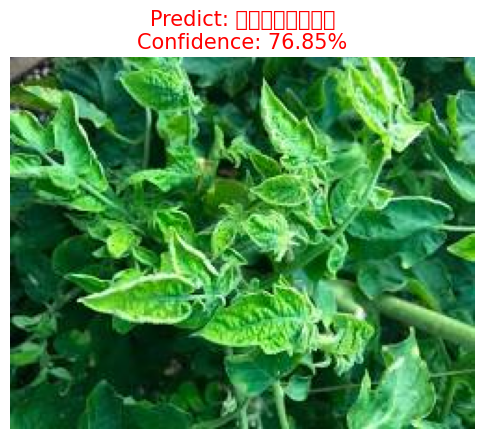

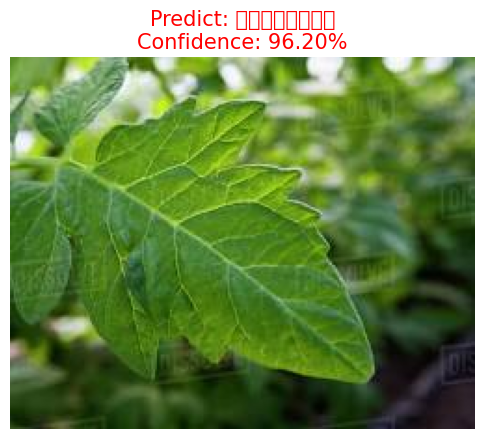

In [44]:
import matplotlib.pyplot as plt
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus':False}
#sns.set(context='notebook', style='ticks', rc=rc)
def visualize_prediction(img_path):
    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_t)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)
    
    label = class_names[preds.item()]
    color = 'red' if '病毒' in label else 'green' # 病毒显示红色，健康显示绿色
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predict: {label}\nConfidence: {conf.item():.2%}", color=color, fontsize=15)
    plt.axis('off')
    plt.show()

# 运行可视化
visualize_prediction('images.jpeg')
visualize_prediction('images (1).jpeg')